# Identifying Age-Related Diseases Using Machine Learning Models
## Author: Boni M. Ale, MD, MSc, MPH
## Affiliations: 
### - Co-Founder & Chief Excecutive Officer - [Health Data Acumen](https://healthdatacumen.com/) (HDA), Nairobi, Kenya 
### - Physician Resident - Internal Medecine, Kenyatta National Hospital, Nairobi, Kenya
### - Senior Research Fellow, Institute of Tropical and Infectious Diseases (UNITID), University of Nairobi, Kenya

### Date: 07 July 2023

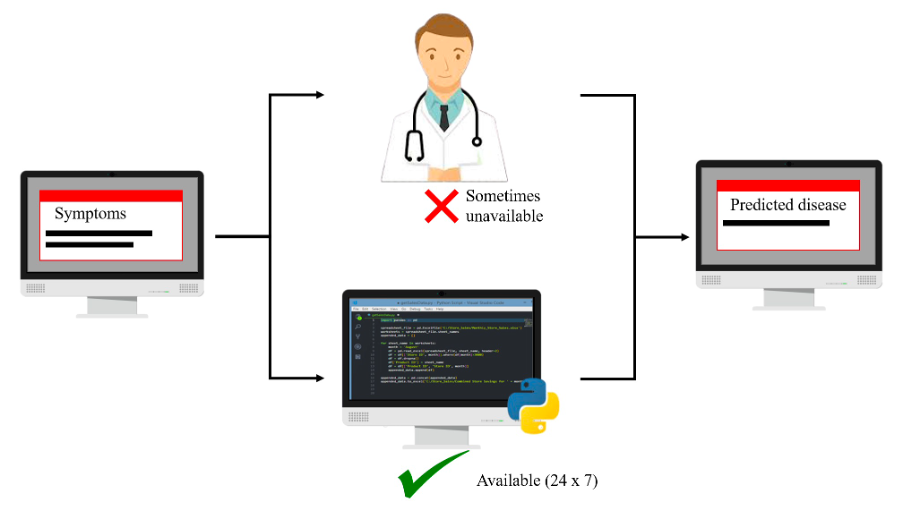

# Table of content

Introduction
1. Exploratory data analysis (EDA)
2. Data Wrangling
3. Data Modelling

Conclusion

# 1. Introduction

Machine learning can be a powerful tool for disease prediction. By analyzing large amounts of data and identifying patterns, machine learning models can learn to recognize subtle indicators and make predictions about disease risk or diagnosis. In this project, I will use machine learning models to detect conditions with measurements of anonymous characteristics. To determine if someone has these medical conditions requires a long and intrusive process to collect information from patients. With predictive models, we can shorten this process and keep patient details private by collecting key characteristics relative to the conditions, then encoding these characteristics.

The aim of this project is to predict if a person has any of three medical conditions using a Kaggle datasets freely available [here](https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview). In order to predict if the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0), I will create models trained on **anonymous measurements** of health characteristics provided in the the **de-identified** datasets.

As you may have noticed, I said anonymous measurements and de-identified datasets. Data de-identification is an important practice in healthcare to protect patient privacy and confidentiality while allowing for the secondary use of data for research, analysis, and other purposes. De-identification involves removing or altering certain identifying information from the data, such as names, addresses, social security numbers, and other direct identifiers. There are few reasons why data de-identification is essential in healthcare. Here are the main reasons:

➤ **Privacy protection**: De-identifying data helps protect patient privacy by preventing the disclosure of sensitive information. 
    
➤ **Compliance with regulations**: Many countries have regulations in place to safeguard patient privacy, such as the Health Insurance Portability and Accountability Act (HIPAA) in the United States and the General Data Protection Regulation (GDPR) in the European Union.
    
➤ **Facilitating research and analysis**: De-identified data enables researchers and analysts to use large datasets for studies and analysis without compromising patient privacy. Researchers can gain insights into disease patterns, treatment effectiveness, public health trends, and more, while ensuring the anonymity of the individuals involved.
    
➤ **Data sharing and collaboration**: De-identification allows healthcare organizations, researchers, and other stakeholders to securely share data with each other for collaborative projects.

However, it's important to note that de-identification is not foolproof, and re-identification risks exist, especially when dealing with highly unique or rare data points. Therefore, it's crucial to employ appropriate de-identification techniques and consider the context and potential risks associated with the data being shared or used.

In our case, this data was shared by InVitro Cell Research, LLC (ICR) which is a privately funded company focused on regenerative and preventive personalized medicine. 

Let's deep dive into our project by first conducting a thourough exploratory data analysis, secondly, clean the datasets, thirdly build diverse models and finally compare the accuracy of these models and identify the best one. 

**Load Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# data transformation and imputation
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Import VarianceThreshold from Scikit-learn
from sklearn.feature_selection import VarianceThreshold


#import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# evaluate models
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

**Load Datasets**

In [2]:
train_raw = pd.read_csv('/Users/boniale/Desktop/Data_Science/ML_iard/data/train.csv')
test = pd.read_csv('/Users/boniale/Desktop/Data_Science/ML_iard/data/test.csv')
greeks_raw = pd.read_csv('/Users/boniale/Desktop/Data_Science/ML_iard/data/greeks.csv')
sample_submission = pd.read_csv('/Users/boniale/Desktop/Data_Science/ML_iard/data/sample_submission.csv')

# 2. Exploratory Data Analysis

## 2.1. Data Description

### → Train Data 

In [3]:
print("Raw Train Data Set's size: ", train_raw.shape)

#separate variables into new data frames
numeric_data = train_raw.select_dtypes(include=[np.number])
cat_data = train_raw.select_dtypes(exclude=[np.number])
cat_data = cat_data.drop(['Id'], axis=1)
print ("There are {} numeric and {} categorical columns in train raw data".format(numeric_data.shape[1],cat_data.shape[1]))

Raw Train Data Set's size:  (617, 58)
There are 56 numeric and 1 categorical columns in train raw data


In [52]:
train_raw.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


It seems like there is 56 numeric variables which include our target ("if the person has one or more of any of the three medical conditions (Class 1)" or "none of the three medical conditions (Class 0)"). Therefore Class is actually a binary categorical variable. 

### → Test Data

In [5]:
print("Raw Test Data Set's size: ", test.shape)

#separate variables into new data frames
numtest_data = test.select_dtypes(include=[np.number])
cattest_data = test.select_dtypes(exclude=[np.number])
cattest_data = cattest_data.drop(['Id'], axis=1)
print ("There are {} numeric and {} categorical columns in test raw data".format(numtest_data.shape[1],cattest_data.shape[1]))

Raw Test Data Set's size:  (5, 57)
There are 55 numeric and 1 categorical columns in test raw data


In [53]:
test.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the test dataset all values are the same apart from the Id.  

### → Greek Data

In [7]:
print("Raw Greek Data Set's size: ", greeks_raw.shape)

#separate variables into new data frames
numgreeks_data = greeks_raw.select_dtypes(include=[np.number])
catgreeks_data = greeks_raw.select_dtypes(exclude=[np.number])
catgreeks_data = catgreeks_data.drop(['Id'], axis=1)
print ("There are {} numeric and {} categorical columns in test raw data".format(numgreeks_data.shape[1],catgreeks_data.shape[1]))

Raw Greek Data Set's size:  (617, 6)
There are 0 numeric and 5 categorical columns in test raw data


In [54]:
greeks_raw.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


### → Data Augmentation

In [9]:
df_train_greeks = train_raw.merge(greeks_raw, on ='Id',how ='left')
df_train_greeks.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


## 2.2. Numerical Variables Exploration

Let's work on numeriacal features.

In [11]:
Target = ['Class']
allFeature = df_train_greeks.columns.tolist()
included_features = [feature for feature in allFeature if feature not in Target]

numericalFeatures = df_train_greeks[included_features].select_dtypes(include=['number'])
categoricalFeatures = df_train_greeks[included_features].select_dtypes(include=['object', ])

In [12]:
num_cols = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL','Class']
num_cnt_cols = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
nominal_cols = ['EJ', 'Alpha','Beta', 'Gamma', 'Delta']

In [13]:
numericalFeatures.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614


In [14]:
categoricalFeatures.head(10)

,Id,EJ,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,B,C,G,D,3/19/2019
1,007255e47698,A,A,C,M,B,Unknown
2,013f2bd269f5,B,A,C,M,B,Unknown
3,043ac50845d5,B,A,C,M,B,Unknown
4,044fb8a146ec,B,D,B,F,B,3/25/2020
5,04517a3c90bd,A,A,C,M,B,10/1/2019
6,049232ca8356,B,A,C,M,B,5/29/2019
7,057287f2da6d,B,A,C,M,B,4/24/2019
8,0594b00fb30a,B,A,C,M,B,2/18/2019
9,05f2bc0155cd,A,A,B,M,B,6/19/2020


👉🏽 There is actually 56 numeric variables and 6 categorical variables apart from 'Id' and 'Epsilon'. I am not interested in using Epsilon because of the nature of the data which I bearly understand. There are date but not clear the date of what it is 😫. 

### 2.2.1. Overall Distribution of Numerical Features

Let's explore the overall distribution of the numerical features.

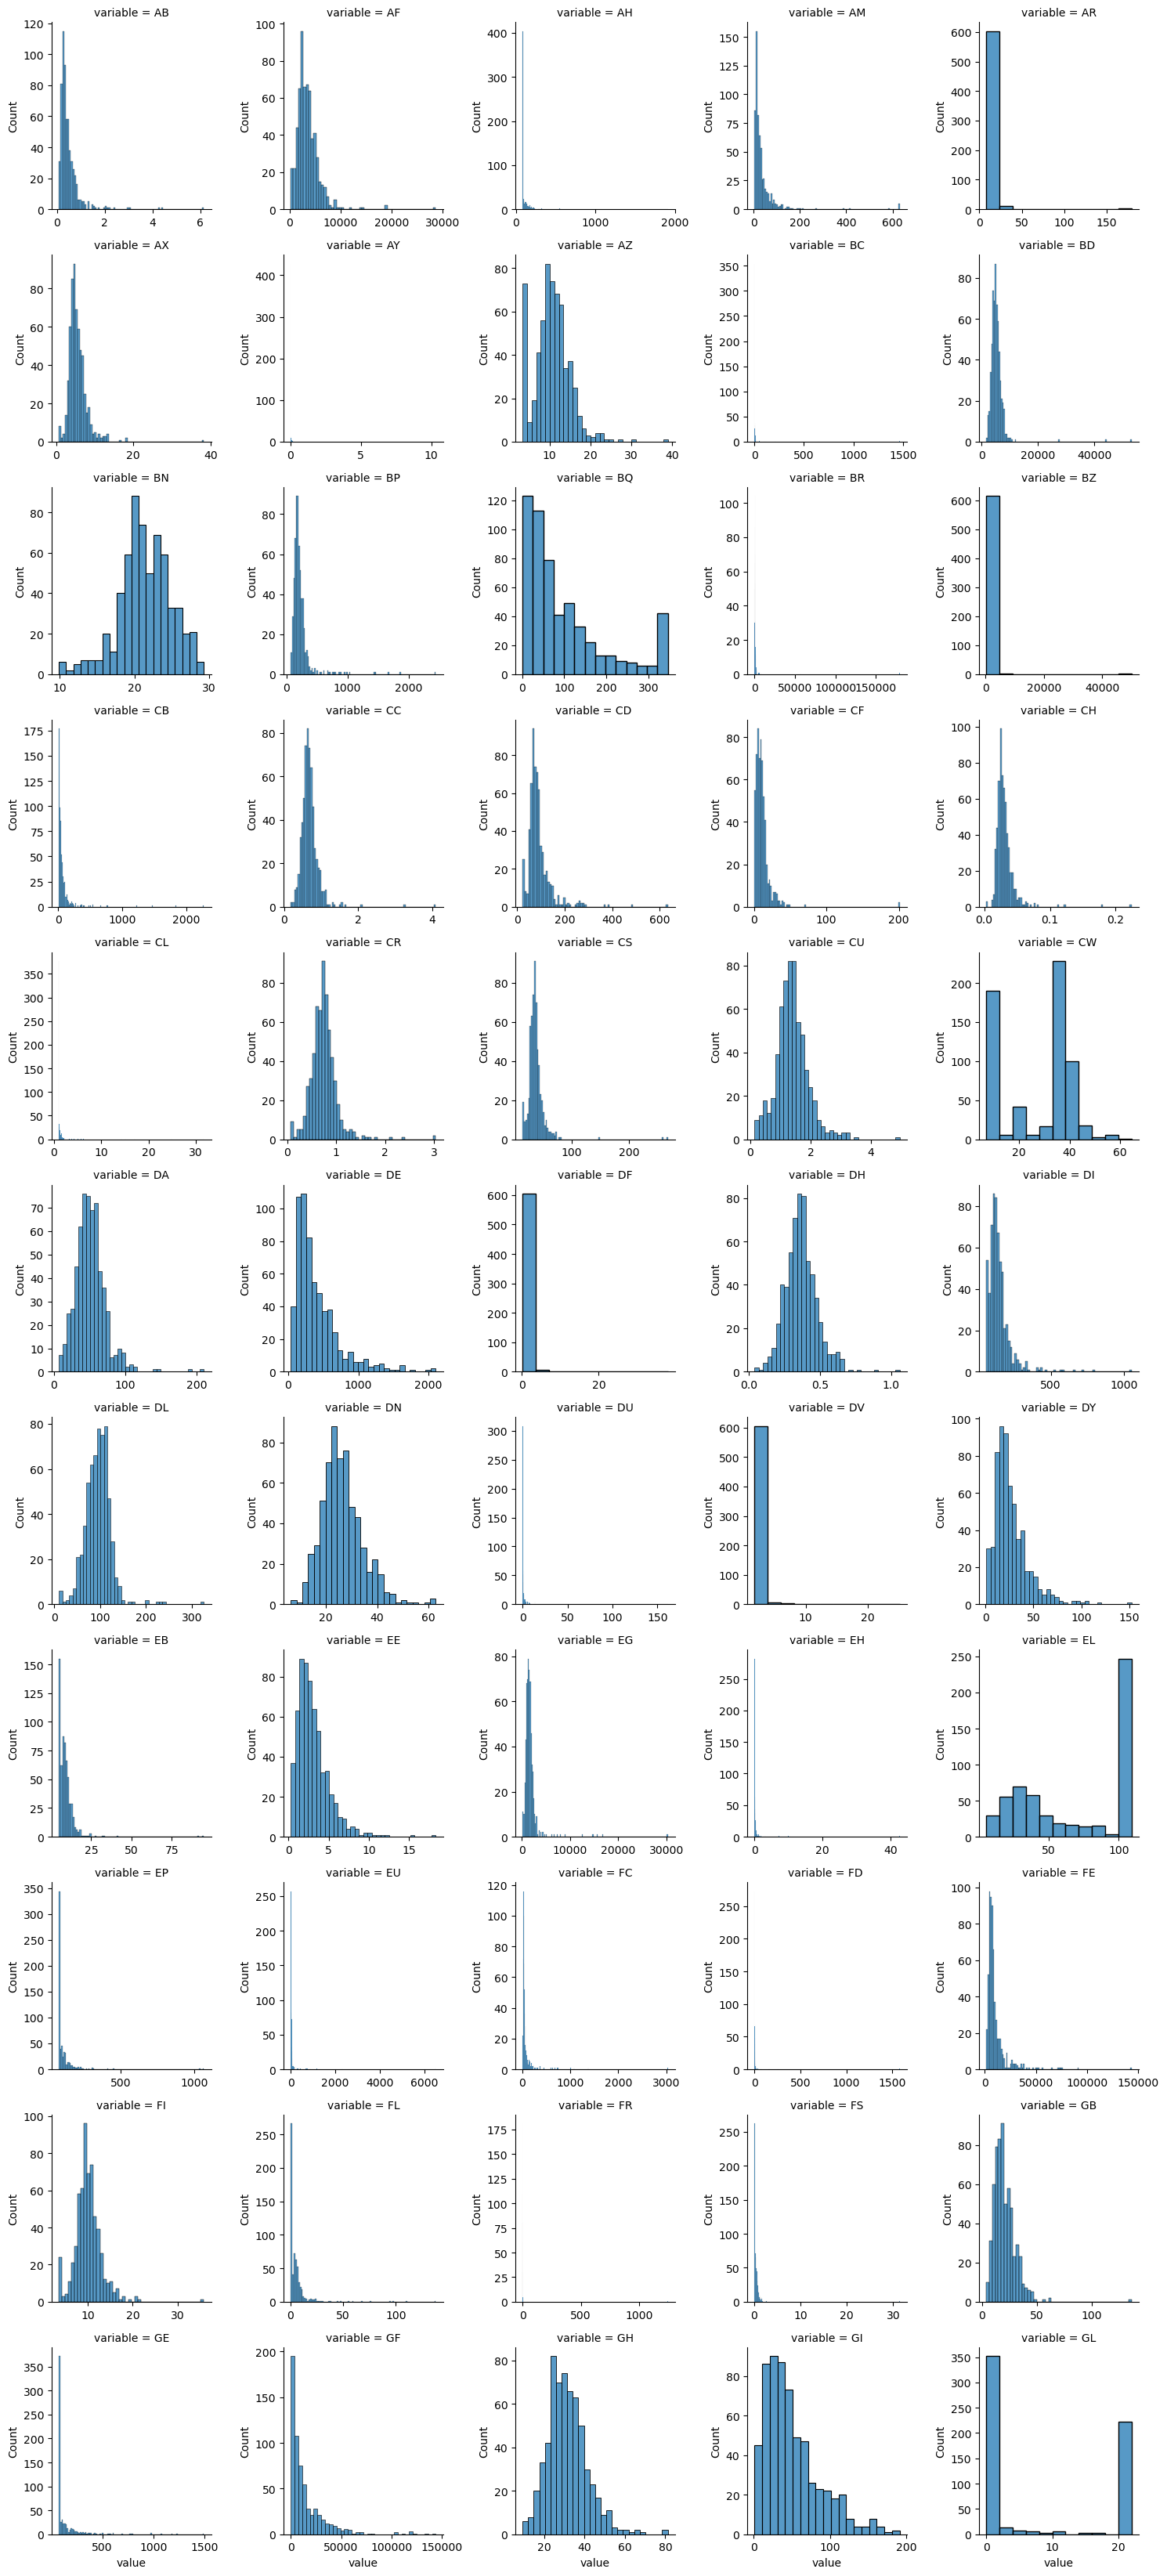

In [15]:
num = [f for f in df_train_greeks.columns if df_train_greeks.dtypes[f] != 'object']
num.remove("Class")
nd = pd.melt(df_train_greeks, value_vars = num)
barplot_train = sns.FacetGrid (nd, col='variable',
                    col_wrap=5, 
                    sharex=False, 
                              sharey = False
                   )
barplot_train = barplot_train.map(sns.histplot, 'value')
plt.show("barplot_train")

We can see that several variables are not normally distributed. 
Are these variables highly correlated among each other ? Let's explore this visually with a heatmap. 

### 2.2.2. Correlation Among all Numerical Features

In [16]:
# Define Display a correlation heatmap Function
def display_correlation_heatmap(df, title):
    corr_mat = np.round(df.corr(), 3)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(corr_mat, annot=True, fmt=".3f", cmap='coolwarm', cbar=False, square=True, linewidths=.5, annot_kws={"size": 12}, ax=ax)

    ax.set_title(title, fontsize=16, pad=20, y=1.05)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

    plt.tight_layout()
    plt.show()
       
def plot_correlation_heatmap(df, column_name):
    correlation_matrix = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation heatmap for {column_name}')
    plt.show()

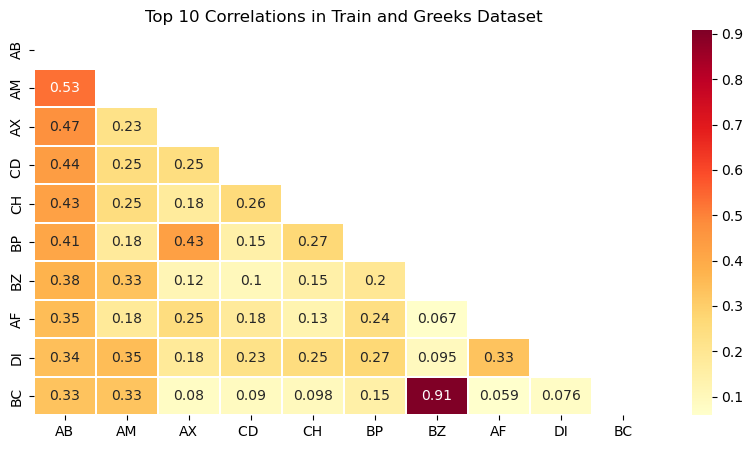

In [17]:
# Display a correlation heatmap
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str='Top Correlations') -> None:
    # Calculate correlation between all variables
    corr = df.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(top_corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# Plot heatmap of top 12 correlations in training data
plot_top_correlations(numericalFeatures, 10, 'Top 10 Correlations in Train and Greeks Dataset')

After plotting the correlation matrix and color scaling the background, we can see the pairwise correlation between all the variables. Most of variables are not highly correlated apart from variable BZ and BC.
This will create multicollinearity and probably overfitting problem in the future models which will make it hard to interpret model. **As we do not have clarity on what BZ and BC are, we will just remove both of them from model features.**

### 2.2.3. Numerical Variables distribution in Target group

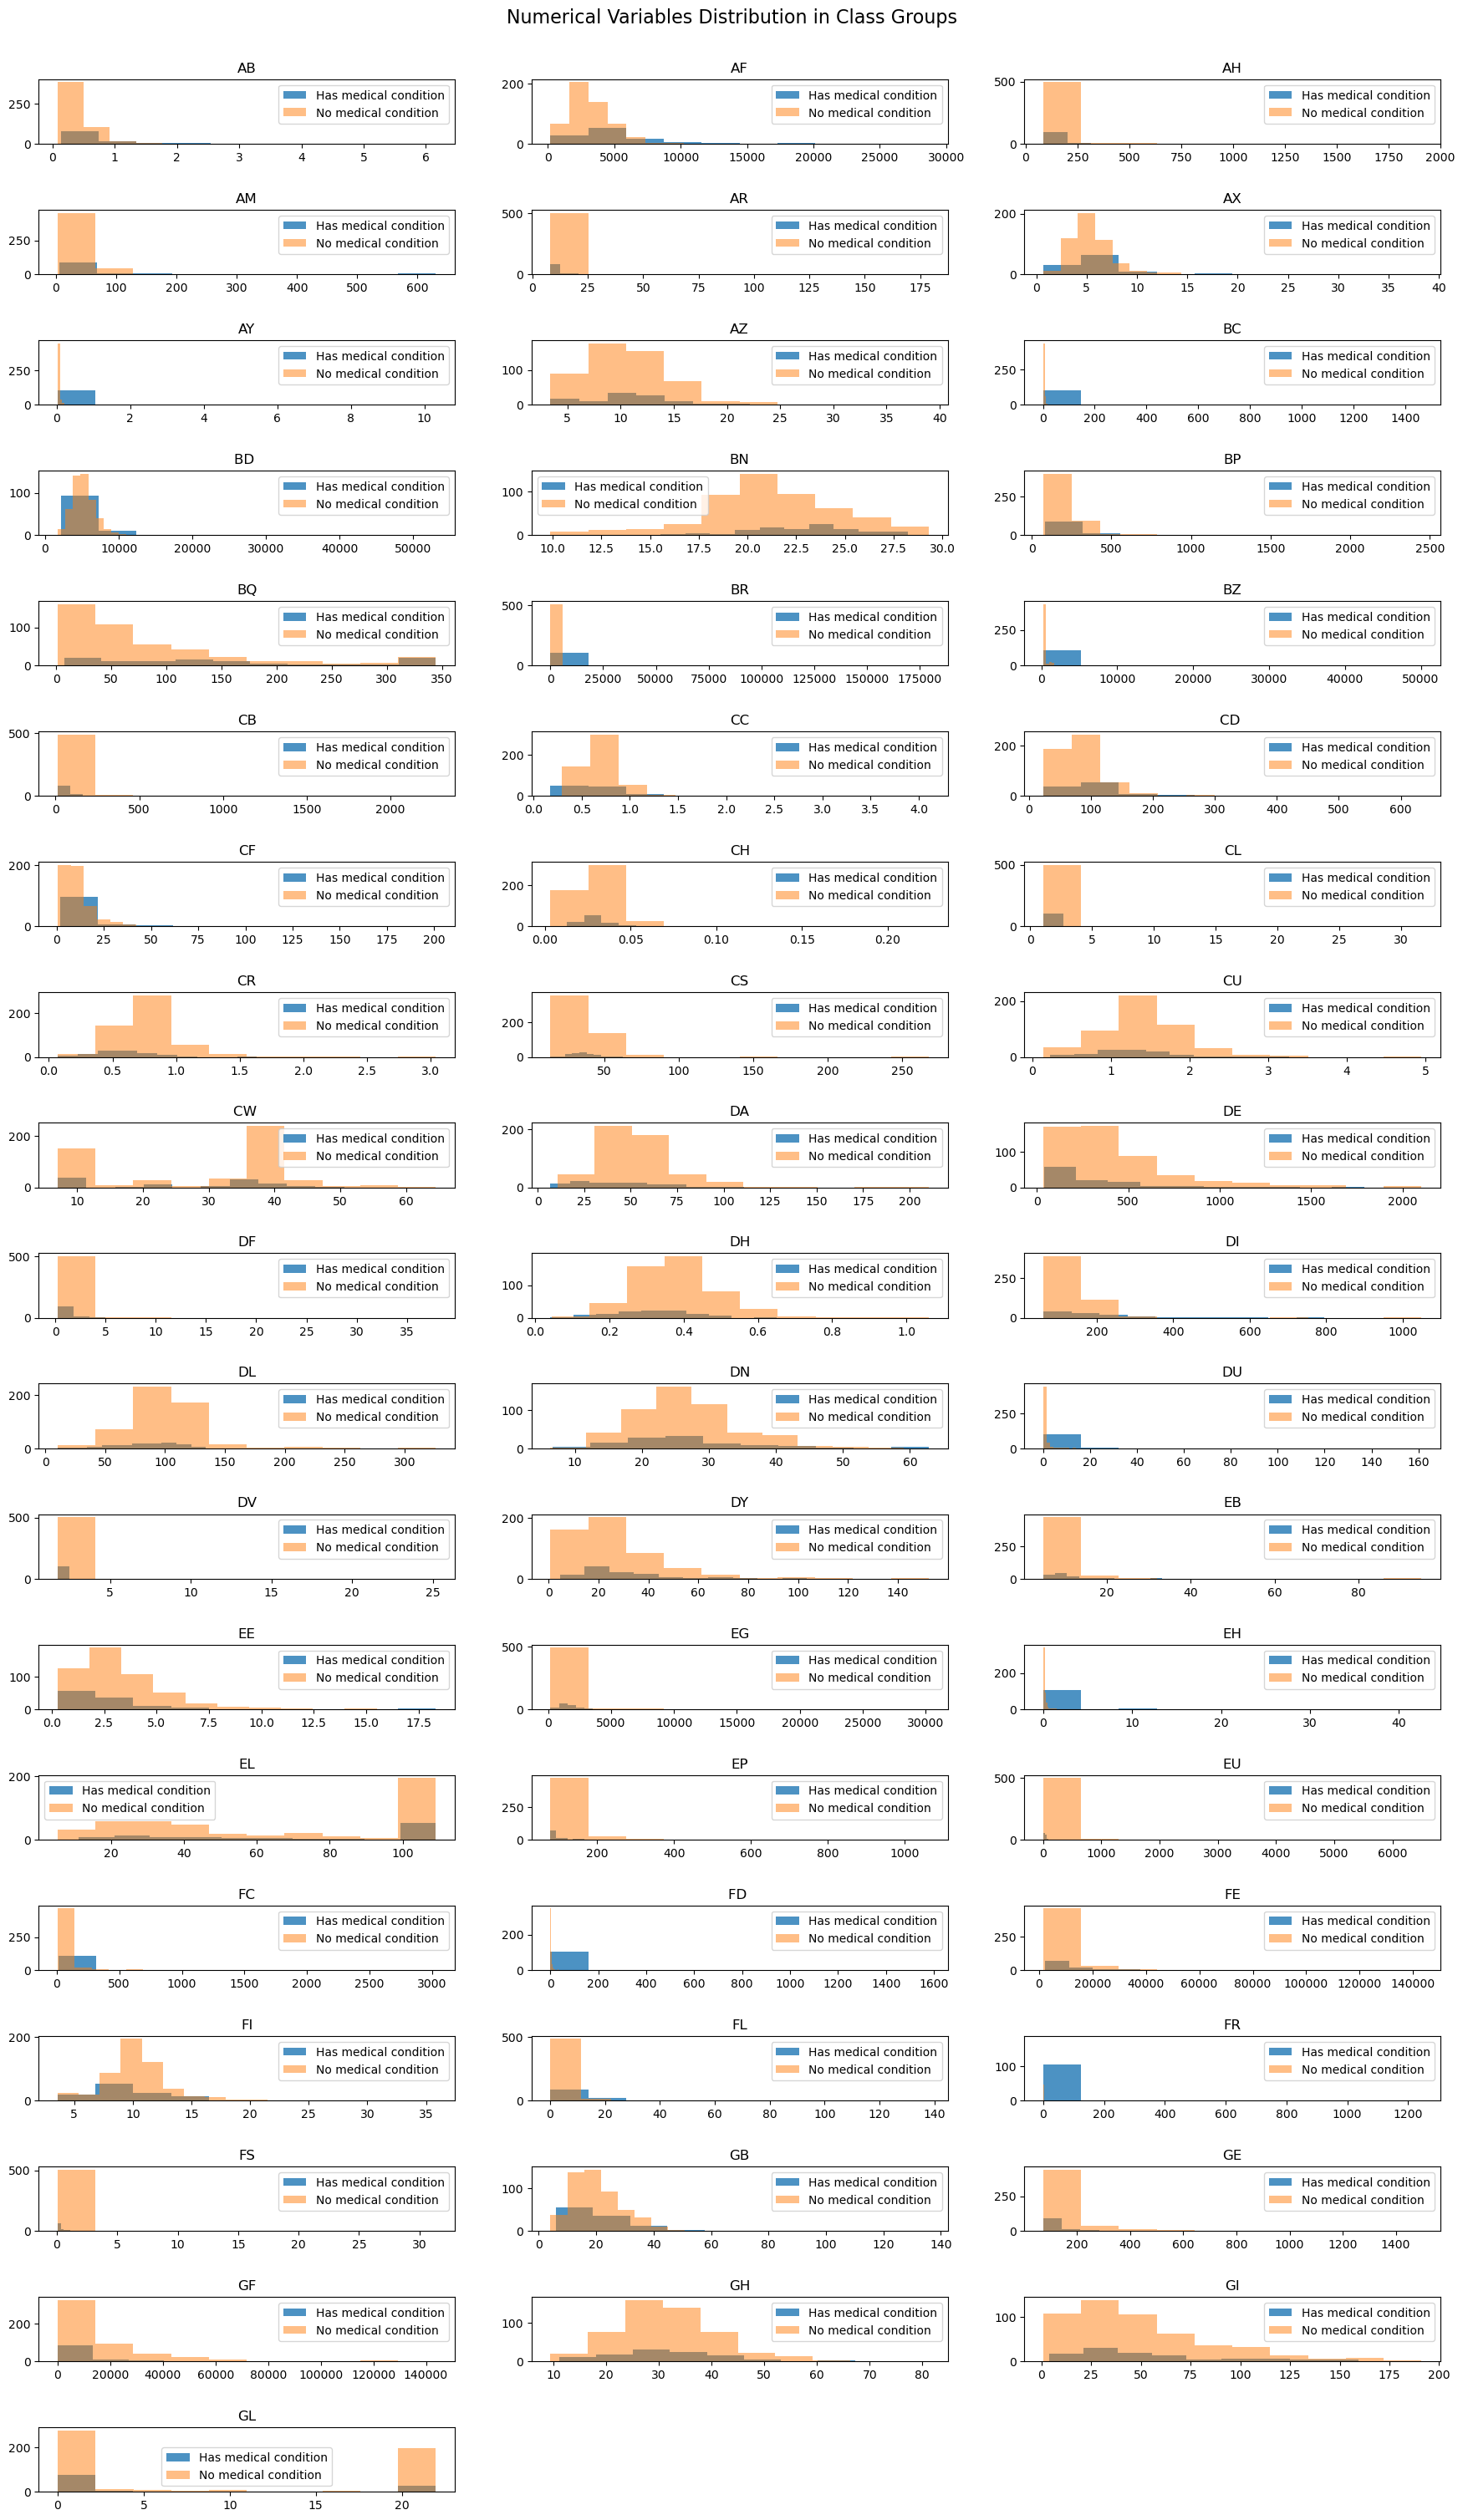

	 Class Rate

AB
(0.132, 0.735]    0.146435
(0.735, 1.338]    0.295082
(1.338, 1.941]    0.500000
(1.941, 2.544]    0.833333
(2.544, 3.147]    0.500000
(3.147, 3.75]          NaN
(3.75, 4.353]     0.000000
(4.353, 4.956]    1.000000
(4.956, 5.559]         NaN
(5.559, 6.162]    1.000000
Name: Class, dtype: float64 

AF
(192.593, 3042.153]       0.096429
(3042.153, 5891.712]      0.206107
(5891.712, 8741.272]      0.380952
(8741.272, 11590.831]     0.625000
(11590.831, 14440.39]     1.000000
(14440.39, 17289.95]      0.000000
(17289.95, 20139.509]     1.000000
(20139.509, 22989.069]         NaN
(22989.069, 25838.628]         NaN
(25838.628, 28688.188]    1.000000
Name: Class, dtype: float64 

AH
(85.2, 200.474]         0.117347
(200.474, 315.748]      0.388889
(315.748, 431.022]      0.333333
(431.022, 546.296]      0.500000
(546.296, 661.57]       0.000000
(661.57, 776.845]            NaN
(776.845, 892.119]      1.000000
(892.119, 1007.393]          NaN
(1007.393, 1122.667]         NaN


In [18]:
##  Distribution on target
i=1
f= plt.figure(figsize =(18,30))
Class_rates =[]

for col in num_cnt_cols:
    plt.subplot(19,3,i)
    n,bins,patchs = plt.hist(df_train_greeks[col].loc[df_train_greeks['Class'] ==1],
                            label =['Has medical condition'],alpha =0.8)
    plt.hist(df_train_greeks[col].loc[df_train_greeks['Class'] ==0],
                            label =['No medical condition'],alpha =0.5)
    plt.title(col)
    plt.legend()
    i+=1
    
    #Survival rate
    Class_rates.append(pd.concat([pd.cut(df_train_greeks[col],bins),df_train_greeks['Class']],axis = 1).groupby([col]).Class.mean())


f.suptitle('Numerical Variables Distribution in Class Groups',fontsize=16, y=1.01)
plt.tight_layout(pad =2.5)
plt.show()

print('\t Class Rate\n')
for cl in Class_rates:
    print(cl,'\n')

The distribution of the data is showing the imbalance distribution of features among those who have the diseases and those who doesn't.

**Let's see if we can exclude some of the numeric feature's columns from models which have not significant mean of diagnosed**

In [19]:
mean_per_class ={}
for col in num_cnt_cols:
    mean_per_class.update({col:df_train_greeks[df_train_greeks['Class'] ==1][col].mean()/(df_train_greeks[df_train_greeks['Class'] ==0][col].mean() + df_train_greeks[df_train_greeks['Class'] ==1][col].mean())})

In [20]:
pr = pd.DataFrame(data = mean_per_class.values(),index = num_cnt_cols)
pr.rename(columns = {0:'Class1_percentage'},inplace =True)
pr.sort_values(by ='Class1_percentage',ascending =False).T

,FR,DU,BC,FD,EH,AY,BR,FL,AM,BZ,...,EP,DH,GE,DA,CR,EE,DE,GL,GF,EU
Class1_percentage,0.92938,0.906085,0.899074,0.89344,0.870828,0.751835,0.74617,0.735579,0.705995,0.704574,...,0.469556,0.455731,0.445469,0.439837,0.438828,0.435226,0.429058,0.391896,0.370135,0.317557


### 2.3. Categorical Variables Distribution in Class Groups

EJ
A    0.126126
B    0.202532
Name: Class, dtype: float64 

Alpha
A    0.0
B    1.0
D    1.0
G    1.0
Name: Class, dtype: float64 

Beta
A    1.000000
B    0.267327
C    0.113022
Name: Class, dtype: float64 

Gamma
A    1.0
B    1.0
E    1.0
F    1.0
G    1.0
H    1.0
M    0.0
N    0.0
Name: Class, dtype: float64 

Delta
A    0.306667
B    0.118421
C    0.312500
D    0.500000
Name: Class, dtype: float64 



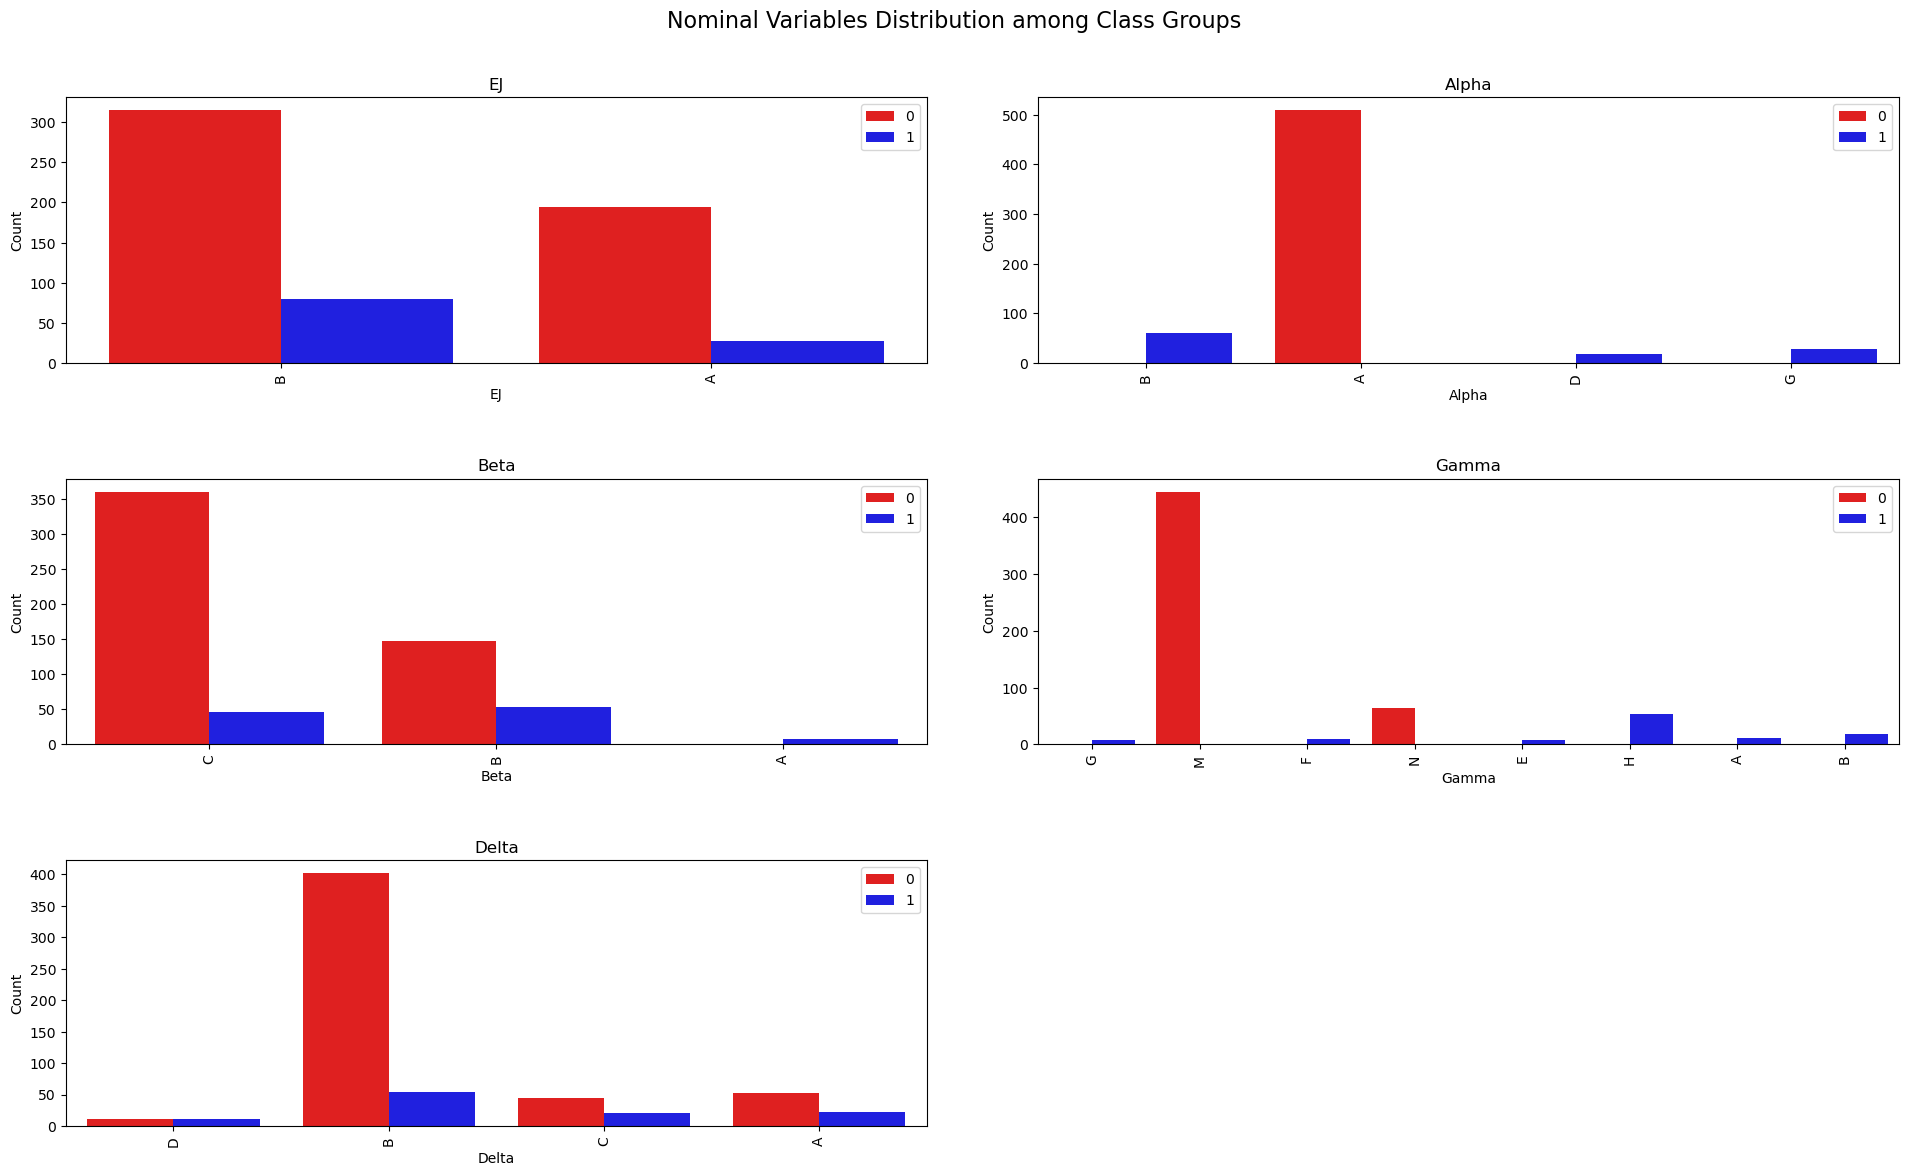

In [21]:
plt.figure(figsize =(20,12))
i = 1
for col in nominal_cols:
    cnt =pd.DataFrame(df_train_greeks[col].value_counts().reset_index())
    t = df_train_greeks.loc[df_train_greeks[col].isin(cnt['index'])]
    plt.subplot(3,2,i)
    sns.countplot(data =t, x =col,hue ='Class',palette=['r','b'])
    
    plt.legend(loc = 'upper right')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(rotation =90)
    plt.title(col)
    i+=1
    print(df_train_greeks.groupby([col]).Class.mean(),'\n')
plt.tight_layout(pad =4)
plt.suptitle('Nominal Variables Distribution among Class Groups', fontsize =16, y=1.01)
plt.show()

📍 This has shown that these categorical variables are not well distributed among groups of people with one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0).

➤ EJ has 2 modalities which are A and B. There are more patients diagnosed with one or more of any of the three medical conditions in B than those in A.

➤ All patients in modality A in alpha have none of the three medical conditions.

➤ From the exploration of test data, Delta, Gamma and Beta are not present. As we have state previously for Alpha variable, there are some categories where there is no diagnosed patients on one of three conditions. This is more or less the same case in Gamma and Delta. It will be better to convert them into integer to improve the analysis on this characteristics. 

🙆🏾‍♂️ Unfortunately, these features are not present in the test dataset. So we may not focus on them during the data modelling process. 

Let's have a look at our target then and understand more its distribution 🏊🏽‍♀️

## 2.4. Target Distribution

First, let's first calculate the frequency table for those have one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0). Secondly, we will generate the percentages in each group. Finaly, we will do a visualisation to show the distribution of our target.

#### *Frequency Table of Class*

In [22]:
freq_tab = pd.crosstab(index = df_train_greeks["Class"],  # Make a crosstab
                     columns="Total")                  # Name the count column
freq_tab

col_0,Total
Class,
0,509
1,108


#### *Percentage Table of Class*

In [23]:
my_tab = pd.crosstab(index = df_train_greeks["Class"],  # Make a crosstab
                     columns="Percentage")                  # Name the count column

my_tab/my_tab.sum()*100 # Calculate the percentages 

col_0,Percentage
Class,
0,82.495948
1,17.504052


#### *Visualisation of Class*

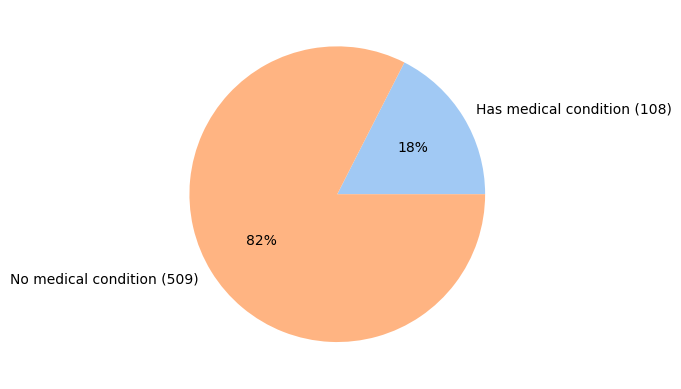

In [24]:
#define data
data_targ = [108, 509]
labels = ['Has medical condition (108)', 'No medical condition (509)']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:50]

#create pie chart
plt.pie(data_targ, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

⎈ In the train dataset around 18% subjects only have been diagnosed with one the three conditions.

⎈ This look like an extremely imbalance data as the number of people who has one or more of any of the three medical conditions is quite smaller than people with none of the three medical conditions. In the data wrangling part, we will see how to handle such issue. 

The distribution of the data confirmed the imbalance distribution of our features and target.

## 2.5. Data Wrangling

### 2.5.1. Missing Data

#### 2.5.1.1. Missing data exploration

Let's identify any missing value. Depending on the extend, we will decide on droping the variable or imput the data based on the missingness mecanism.

In [25]:
mis_data_count = train_raw.isnull().sum()
mis_data_percent = train_raw.isnull().sum() / len(train_raw) * 100

missing_dataframe = pd.DataFrame({
    'Count': mis_data_count,
    'Percent': mis_data_percent
})



missing_dataframe = missing_dataframe[missing_dataframe.Count > 0]
missing_dataframe.sort_values(by='Count', ascending=False, inplace=True)

print(f"⎆ There are {missing_dataframe.shape[0]} features having missing data.\n")
print("⎆ Missing value features:")
missing_dataframe.head(9)

⎆ There are 9 features having missing data.

⎆ Missing value features:


,Count,Percent
BQ,60,9.724473
EL,60,9.724473
CC,3,0.486224
CB,2,0.324149
FS,2,0.324149
DU,1,0.162075
FC,1,0.162075
FL,1,0.162075
GL,1,0.162075


👀 Let's have a look at missing data visually. 

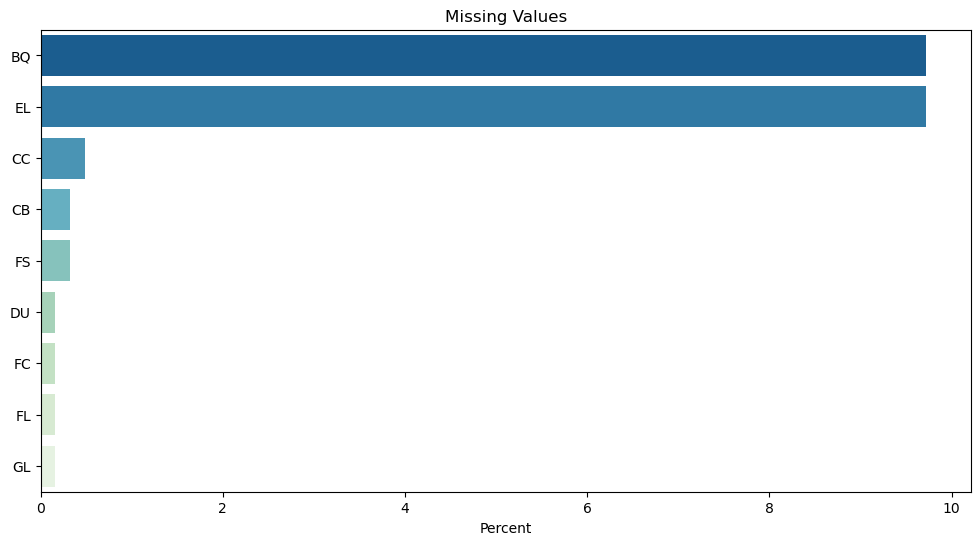

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(y=missing_dataframe.index,
            x=missing_dataframe.Percent,
            palette='GnBu_r')
title = plt.title("Missing Values")
plt.show()

#### 2.5.1.2. Missing Data Imputation

Giving that all these variables missing variables are numeric variables, I will impute them with their medians because 
the distribution of these data values are skewed. 

In [27]:
specific_vars = [
    'BQ', 'EL', 'CC', 'CB', 'FS', 'DU', 'FC', 'FL', 'GL'
]

imputer = SimpleImputer(missing_values=np.NaN, strategy='median')

train_raw[specific_vars] = pd.DataFrame(imputer.fit_transform(train_raw[specific_vars]), index = train_raw.index)

Now, let's verify if there are still missing data in our dataset. 

In [28]:
sum(train_raw.isnull().sum())

0

🕺🏽 There are no more missing data in our train data. 

### 2.5.2. Data Recoding

In [29]:
# convert categorical data in numerical for categorical column
train_raw['EJ'] = train_raw['EJ'].replace({'A': 0, 'B': 1})
test['EJ'] = test['EJ'].replace({'A': 0, 'B': 1})

### 2.5.3. Dropping Highly Correlated Variables

Remember in section '2.2.2. Correlation Among all Numerical Features' features BC and BZ where highly correlated with a correlation coefficient of 91%. Thus, I would prefer to remove one of them from the databases to avoid overfitting and instability of my models. 

In [30]:
train_raw = train_raw.drop(['BC'], axis=1)
test = test.drop(['BC'], axis=1)

# 3. Data Modelling

## 3.1. Data Spliting And Data Standardisation

In [31]:
# data spliting
X = train_raw.drop(['Id','Class'], axis=True)
Y = train_raw['Class']
data_cols = X.columns[1:-1].to_list()

# Split the dataset into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

**Let's have a look at the distribution of our target in the test data set.**

In [32]:
my_tab_train = pd.crosstab(index = y_train,  # Make a crosstab
                     columns="Percentage")                  # Name the count column

my_tab_train/my_tab_train.sum()*100 # Calculate the percentages 

col_0,Percentage
Class,
0,81.438515
1,18.561485


In [33]:
my_tab_test = pd.crosstab(index = y_test,  # Make a crosstab
                     columns="Percentage")                  # Name the count column

my_tab_test/my_tab_test.sum()*100 # Calculate the percentages 

col_0,Percentage
Class,
0,84.946237
1,15.053763


**Well, it looks more or less the same as in the train dataset (18.5% versus 15%).**

Let's go ahead and scale the dataset then. 

In [34]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3.2. Building Models

We will always use the same workflow for each model starting from training the model using the training dataset and then predict the response for the test dataset. 

### 3.2.1. Logistic Regression Model

Let's start from the basic!😀

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.).

In [35]:
# Create a logistic Regression classifier
logreg = LogisticRegression()

# Train the classifier on the training data
logreg.fit(X_train, y_train)

# Make predictions on the testing data
logy_pred = pd.DataFrame(logreg.predict(X_test), columns = ["Predicted Diagnosis"])
logy_pred

,Predicted Diagnosis
0,1
1,0
2,0
3,1
4,0
...,...
181,0
182,0
183,0
184,0


**Model Evaluation**

In [36]:
# Evaluate the accuracy of the classifier

log_metrics = metrics.accuracy_score(y_test, logy_pred)

# Model Precision
prec_log = metrics.precision_score(y_test, logy_pred)

# Model Recall
rec_log = metrics.recall_score(y_test, logy_pred)

In [37]:
log_models_accuracy = pd.DataFrame({'Parameters':['Accuracy', 'Precision', 'Recall'],
                                'Score':[log_metrics, prec_log , rec_log]
                           })

log_models_accuracy

,Parameters,Score
0,Accuracy,0.870968
1,Precision,0.562500
2,Recall,0.642857


**Result Interpretation**

📌 Our model has 82% of accuracy. This means that using a logistic regression model help to predict 82% of people with one the three conditions which is not that bad. Remember that we are dealing with a rare diseases in this population.

📌 For further evaluation, we can also check precision and recall of model.

Precision and recall are evaluation metrics used to assess the performance of classification models, particularly in binary classification problems.

💡 Precision measures the proportion of correctly predicted positive instances out of all instances predicted as positive. It quantifies how reliable the model's positive predictions are. Mathematically, precision is calculated as:

                                Precision = TP / (TP + FP)
                                
where TP is the number of true positives (correctly predicted positive instances) and FP is the number of false positives (negative instances incorrectly predicted as positive). A high precision indicates that the model has a low rate of false positives.

💡 Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted positive instances out of all true positive instances. It captures the ability of the model to identify positive instances correctly. Mathematically, recall is calculated as:

                                Recall = TP / (TP + FN)
                                
where FN is the number of false negatives (positive instances incorrectly predicted as negative). A high recall indicates that the model has a low rate of false negatives.

Interpreting precision and recall scores depends on the specific problem and the relative importance of false positives and false negatives.

📌 In healthcare, these concepts are common used to evaluate a diagnosis tools and there are called sensitivity and specificity of a of a medical test.

☞ In the context of medical testing, specificity and sensitivity are two important measures used to evaluate the performance of a diagnostic test, including tests for rare diseases. Let's explore what specificity and sensitivity mean and which one is the most important in clinical practice.

⎈ Sensitivity is the ability of a screening test to correctly identify individuals who have the condition or disease being screened for. It represents the proportion of true positives (correctly identified individuals with the condition) out of all individuals with the condition. A high sensitivity indicates that the test has a low rate of false negatives, meaning it effectively detects the presence of the condition.


⎈ Specificity, on the other hand, is the ability of a screening test to correctly identify individuals who do not have the condition or disease. It represents the proportion of true negatives (correctly identified individuals without the condition) out of all individuals without the condition. A high specificity indicates that the test has a low rate of false positives, meaning it accurately identifies individuals without the condition.


📌 The importance of sensitivity and specificity depends on the clinical context and the potential consequences of false positives and false negatives. 

→ In some situations, such as when the condition being screened for is severe or has serious consequences, it is crucial to have high sensitivity to minimize false negatives. For example, in cancer screening, a high sensitivity ensures that individuals with cancer are less likely to be missed and can receive appropriate follow-up diagnostic tests and treatment.

→ On the other hand, in certain scenarios, specificity may be more important. For instance, if a positive screening result leads to invasive and potentially risky follow-up procedures, it is essential to have high specificity to minimize false positives. This helps avoid unnecessary interventions and potential harm to individuals who do not have the condition.

✔️ In practice, the desired balance between sensitivity and specificity depends on various factors, including the nature of the condition being screened for, available follow-up diagnostic tests, potential interventions or treatments, cost implications, and patient preferences. The selection of an appropriate screening test should consider the specific context and aim to optimize both sensitivity and specificity based on the priorities and risks involved.

**The receiver operating characteristic (ROC)**

The roc curve is another common tool used with binary classifiers. 
The Area Under the Curve (AUC) value in a Receiver Operating Characteristic (ROC) curve is a commonly used metric for evaluating the performance of a binary classification model. The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1 - specificity) at various classification thresholds.

The AUC value represents the overall discriminative power of the model across all possible classification thresholds. It ranges from 0 to 1, where a value of 0.5 indicates a random classifier, and a value of 1 indicates a perfect classifier.

In a nutshell, the dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

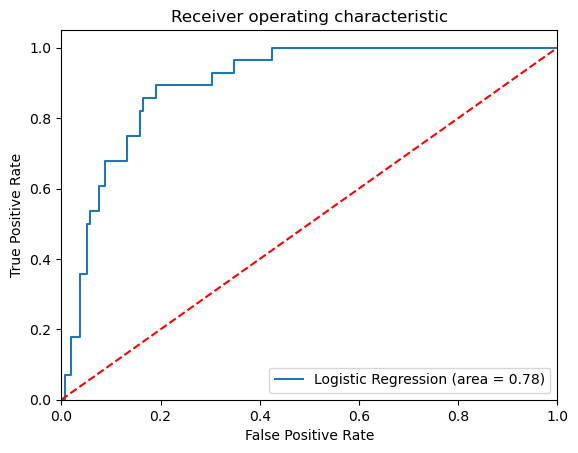

In [38]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label ='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**→ The receiver operating characteristic (ROC)**

Here we have a score of 67% (value greater than 0.5) which indicates that the model has some discriminatory ability. 

However, given that we are in heathcare, thus we will need a model with a stronger discriminatory ability. 

### 3.2.2. K-Nearest Neighbors (KNN) Classification 

The KNeighborsClassifier is a machine learning algorithm used for classification tasks, including binary classification. It is a type of instance-based or lazy learning algorithm that makes predictions based on the similarity of the input data to the training instances.

In the case of binary classification, the KNeighborsClassifier algorithm assigns a class label to a new data point based on the class labels of its k nearest neighbors in the training set. The value of k, which is a hyperparameter, determines the number of neighbors considered.

In [39]:
# Create an instance of the KNeighborsClassifier with a number of neighbors (k) of 4
neigh = KNeighborsClassifier(n_neighbors = 4)

# Train the classifier on the training data
neigh.fit(X_train, y_train)

# Make predictions on the testing data
Pred_y = pd.DataFrame(neigh.predict(X_test), columns = ["Predicted Diagnosis"])
Pred_y

,Predicted Diagnosis
0,0
1,0
2,0
3,0
4,0
...,...
181,0
182,0
183,0
184,0


In [40]:
# Evaluate the accuracy of the classifier
knn = metrics.accuracy_score(y_test, Pred_y)

# Model Precision
prec_knn = metrics.precision_score(y_test, Pred_y)


# Model Recall
rec_knn = metrics.recall_score(y_test, Pred_y)

In [41]:
knn_models_accuracy = pd.DataFrame({'Parameters':['Accuracy', 'Precision', 'Recall'],
                                'Score':[knn, prec_knn, rec_knn]
                           })

knn_models_accuracy

,Parameters,Score
0,Accuracy,0.876344
1,Precision,0.777778
2,Recall,0.250000


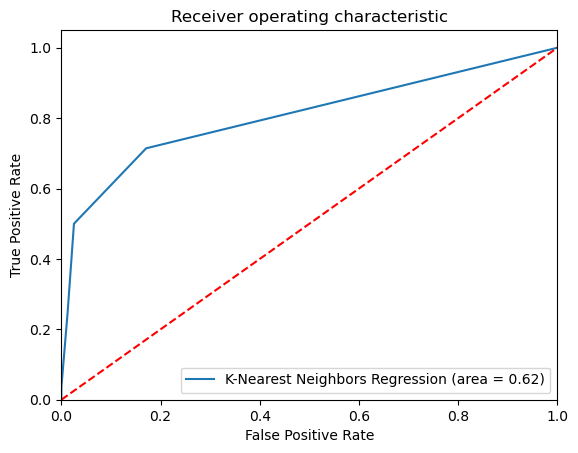

In [42]:
neigh_roc_auc = roc_auc_score(y_test, neigh.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label ='K-Nearest Neighbors Regression (area = %0.2f)' % neigh_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC')
plt.show()

### 3.3.3. Support vector machines (SVMs)

Support Vector Machine (SVM) classification is a popular supervised machine learning algorithm used for binary and multi-class classification tasks. It is a powerful algorithm for finding the optimal decision boundary that separates different classes in a dataset.

The basic idea behind SVM classification is to find a hyperplane in a high-dimensional feature space that best separates the data points into different classes. The hyperplane is defined by a subset of the training data points called support vectors, which are the closest points to the decision boundary.

The key concept in SVM is maximizing the margin, which is the distance between the decision boundary and the support vectors. SVM aims to find the decision boundary that has the largest margin, as it is expected to generalize well to unseen data. The margin represents the confidence of the classifier's predictions and helps to reduce the risk of overfitting.

I will use here the Radial Basis Function (RBF) Kernel. The RBF kernel is commonly used when the decision boundary is complex or when there is no prior knowledge about the data distribution. It is effective in capturing non-linear relationships and is often the default choice for SVMs. However, it can be sensitive to the choice of hyperparameters, such as the gamma parameter.

In [43]:
# Create an SVM classifier
clf = svm.SVC(kernel='rbf', probability = True)  

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_svm = pd.DataFrame(clf.predict(X_test), columns = ["Predicted Diagnosis"])
y_pred_svm

,Predicted Diagnosis
0,1
1,0
2,0
3,1
4,0
...,...
181,0
182,0
183,0
184,0


In [44]:
# Evaluate the accuracy of the classifier
accuracy_svm = metrics.accuracy_score(y_test, y_pred_svm)


# Model Precision
prec_svm = metrics.precision_score(y_test, y_pred_svm)

# Model Recall
rec_svm = metrics.recall_score(y_test, y_pred_svm)

In [45]:
svm_models_accuracy = pd.DataFrame({'Parameters':['Accuracy', 'Precision', 'Recall'],
                            'Score':[accuracy_svm, prec_svm, rec_svm]
                           })

svm_models_accuracy

,Parameters,Score
0,Accuracy,0.876344
1,Precision,0.666667
2,Recall,0.357143


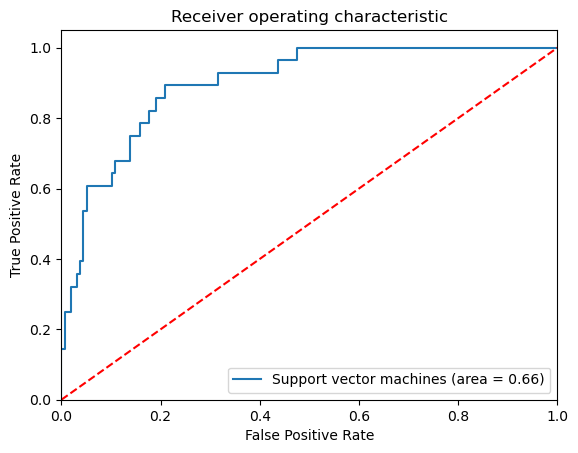

In [46]:
clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label ='Support vector machines (area = %0.2f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.savefig('SVM_ROC')
plt.show()

### 3.3.4. Random Forest Model

There are several **advantages of Random Forest classifiers**, here are few:

1. It may be used to solve problems involving classification and regression.

2. It eliminates overfitting because the result is based on a majority vote or average.

3. It works well even when there are null or missing values in the data.

4. Each decision tree formed is independent of the others, demonstrating the parallelization characteristic.

5. Because the average answers from a vast number of trees are used, it is extremely stable.

6. It preserves diversity since all traits are not taken into account while creating each decision tree, albeit this is not always the case.

7. It is unaffected by the dimensionality curse. The feature space is minimized since each tree does not evaluate all of the properties.

8. We don't need to separate data into train and test since there will always be 30% of the data that the bootstrap decision tree will miss.

But, like advantages, there are a **few disadvantages of this algorithm** as well. Some of them are:

1. When employing a random forest, additional computing resources are required.

2. When compared to a decision tree algorithm, it takes longer.

**The 'Gini' Criterion**

In a random forest classifier, the criterion "gini" refers to the measurement used to evaluate the quality of a split during the tree-building process. Gini impurity is a measure of the impurity or disorder within a node of a decision tree. It quantifies how mixed the classes are within a given node.

In the context of a random forest classifier, which combines multiple decision trees, the Gini impurity is used as a criterion to determine the optimal splits at each tree's node. The final prediction is then based on the aggregated results from all the trees in the random forest.

In [47]:
# Let's create a random forest classifier
randforstcl = RandomForestClassifier(random_state=0, 
                             criterion='gini') # Use gini criterion to define feature importance

# Now train the classifier
randforstcl.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = pd.DataFrame(randforstcl.predict(X_test), columns = ["Predicted Diagnosis"])
y_pred

,Predicted Diagnosis
0,1
1,1
2,0
3,1
4,0
...,...
181,0
182,0
183,0
184,0


**Model Evaluation**

In [48]:
# Evaluate the accuracy of the classifier
rf = metrics.accuracy_score(y_test, y_pred)

# Model Precision
prec_rf = metrics.precision_score(y_test, y_pred)

# Model Recall

rec_rf = metrics.recall_score(y_test, y_pred)

In [49]:
rf_models_accuracy = pd.DataFrame({'Parameters':['Accuracy', 'Precision', 'Recall'],
                            'Score':[rf, prec_rf, rec_rf]
                           })

rf_models_accuracy

,Parameters,Score
0,Accuracy,0.897849
1,Precision,0.736842
2,Recall,0.500000


Our model predict accurately 90% of patients who have been diagnosed with one the three conditions. 

This accuracy is good even though we are in healthcare and we may need a higher level of accuracy. 

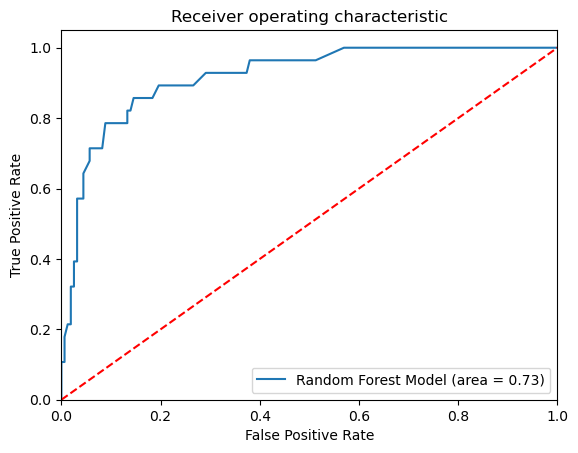

In [50]:
randforstcl_roc_auc = roc_auc_score(y_test, randforstcl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, randforstcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label ='Random Forest Model (area = %0.2f)' % randforstcl_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.savefig('rf_ROC')
plt.show()

# 3.3. Model Comparison

In [51]:
models_accuracy = pd.DataFrame({'Model':['Multiple Logistic Regression', 'K-Nearest Neighbors model ', 'Support vector machines', 'Random Forest Model'],
                            'Accuracy':[log_metrics, knn, accuracy_svm, rf],'Precision':[prec_log, prec_knn, prec_svm, prec_rf], 'Recall':[rec_log, rec_knn, rec_svm, rec_rf], 'AUC':[logit_roc_auc, neigh_roc_auc, clf_roc_auc, randforstcl_roc_auc]
                           })
models_accuracy.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,AUC
3,Random Forest Model,0.897849,0.736842,0.500000,0.734177
1,K-Nearest Neighbors model,0.876344,0.777778,0.250000,0.618671
2,Support vector machines,0.876344,0.666667,0.357143,0.662749
0,Multiple Logistic Regression,0.870968,0.562500,0.642857,0.777125


# Conclusion

In this project, I have used the " ICR - Identifying Age-Related Conditions" data which is still in competion on Kaggle at the time I am finalising this analysis. 

First of all, I have conducted a detailed exploratory data analysis to understand the data and important features.

Secondly, I have modelled the data using multiple logistiic regression model, the K-Nearest neighbors classification, the support vector machines and random forest regression.

Thirdly, I have compared the performance of each of model and arrange them from the most accurate to the less.

Overall, random forest classifier is the best for the modelling of this data with an accuracy of 90% overall. In addition, the random forest classifier has a 67% of precision and recall which is basically higher than the precision and recall of most of other models apart from the K-Nearest Neighbors model (71% of precision). In addition, the area under the curve value (> 0.80) of the random forest classifier shows that this model is very close to a perfect classifier.

However, the K-Nearest Neighbors model and Support vector machine have performed well with an accuracy > 85%.